In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory

tf.config.list_physical_devices('GPU')

2024-03-10 21:23:21.871200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 21:23:21.871262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 21:23:21.906301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 21:23:21.989998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 21:23:23.947397: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_dir = '../Generator/dataset/train'
test_dir = '../Generator/dataset/test'

In [3]:
IMG_SIZE = 500
BATCH_SIZE = 32
RANDOM_SEED = random.randint(0, 1000)
print(RANDOM_SEED)

516


In [4]:
train_dataset = image_dataset_from_directory(
    train_dir,
    #labels='inferred',
    #validation_split=0.2,
    #subset="training",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
    )

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
    )


Found 3000 files belonging to 4 classes.


2024-03-10 21:23:39.938598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 21:23:39.938970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 21:23:39.939238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 1000 files belonging to 4 classes.


In [5]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 500, 500, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomCrop(IMG_SIZE, IMG_SIZE)
])

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(4, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

In [14]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [18]:
history = model.fit(train_dataset, epochs=25, batch_size=32, validation_data=test_dataset)

Epoch 1/25
94/94 [==============================] - 37s 391ms/step - loss: 1.1620 - acc: 0.4823 - val_loss: 1.3154 - val_acc: 0.3930
Epoch 2/25
94/94 [==============================] - 37s 393ms/step - loss: 1.1550 - acc: 0.4880 - val_loss: 1.2737 - val_acc: 0.3840
Epoch 3/25
94/94 [==============================] - 37s 393ms/step - loss: 1.1442 - acc: 0.4947 - val_loss: 1.3172 - val_acc: 0.3540
Epoch 4/25
94/94 [==============================] - 37s 392ms/step - loss: 1.1221 - acc: 0.5063 - val_loss: 1.2483 - val_acc: 0.4260
Epoch 5/25
94/94 [==============================] - 37s 394ms/step - loss: 1.1155 - acc: 0.5063 - val_loss: 1.2756 - val_acc: 0.4200
Epoch 6/25
94/94 [==============================] - 37s 395ms/step - loss: 1.1024 - acc: 0.5290 - val_loss: 1.3590 - val_acc: 0.4160
Epoch 7/25
94/94 [==============================] - 37s 395ms/step - loss: 1.0929 - acc: 0.5293 - val_loss: 1.2875 - val_acc: 0.3790
Epoch 8/25
94/94 [==============================] - 37s 393ms/step - 

In [19]:
model.save('models/shape_classifier.h5')

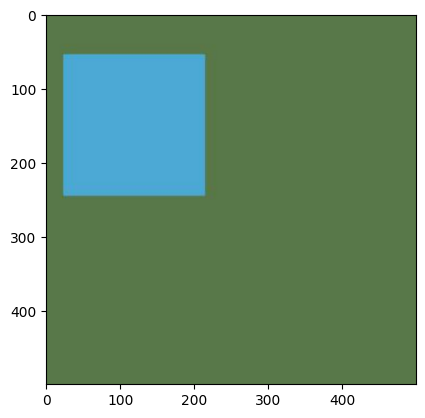

1/1 [==============================] - 0s 22ms/step
[[0. 0. 1. 0.]]


In [11]:
img = np.array([])
for data_batch, label in test_dataset.take(1):
        image = data_batch[random.randint(0,10)].numpy().astype("uint8")
        img = np.append(img, image)
        plt.imshow(image)
        plt.show()
        break
img = img.reshape(IMG_SIZE, IMG_SIZE, 3)
img.astype("float32") / 255
img = np.expand_dims(img, axis=0)

print(model.predict(img).round())

In [17]:
val_loss, val_acc = model.evaluate(test_dataset, batch_size=64)
print(val_loss, val_acc)

32/32 [==============================] - 4s 111ms/step - loss: 1.2988 - acc: 0.4070
1.298773169517517 0.40700000524520874


In [ ]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')

ax = plt.gca()
ax.set_ylim([0, 1])
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
img = tf.keras.preprocessing.image.load_img('cats_and_dogs_small/validation/dogs/dog.1010.jpg', target_size=(150, 150), interpolation='bilinear')

In [ ]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)
result = model.predict(img_array)
print("Result: ", result.round())